# Mango🥭 Leaf🍃🍂 Disease Dataset

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preparation

### Data Loading

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

In [5]:
# Download kaggle dataset and unzip the file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d aryashah2k/mango-leaf-disease-dataset
!unzip mango-leaf-disease-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
  0% 0.00/103M [00:00<?, ?B/s]
100% 103M/103M [00:00<00:00, 1.37GB/s]
Archive:  mango-leaf-disease-dataset.zip
  inflating: Anthracnose/20211008_124249 (Custom).jpg  
  inflating: Anthracnose/20211008_124250 (Custom).jpg  
  inflating: Anthracnose/20211008_124252 (Custom).jpg  
  inflating: Anthracnose/20211008_124253 (Custom).jpg  
  inflating: Anthracnose/20211008_124256 (Custom).jpg  
  inflating: Anthracnose/20211008_124301 (Custom).jpg  
  inflating: Anthracnose/20211008_124302 (Custom).jpg  
  inflating: Anthracnose/20211008_124305 (Custom).jpg  
  inflating: Anthracnose/20211008_124306 (Custom).jpg  
  inflating: Anthracnose/20211008_124310 (Custom).jpg  
  inflating: Anthracnose/20211008_124312 (Custom).jpg  
  inflating: Anthracnose/20211008_124334 (Custom).jpg  
  inflating: Anthracnose/20211008_124336 (Custom).jpg  
  infla

In [6]:
# Specify the correct path to the zip file
zip_file_path = "/content/mango-leaf-disease-dataset.zip"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("mango_image/dataset")  # Ekstrak ke folder "mango_image/dataset"

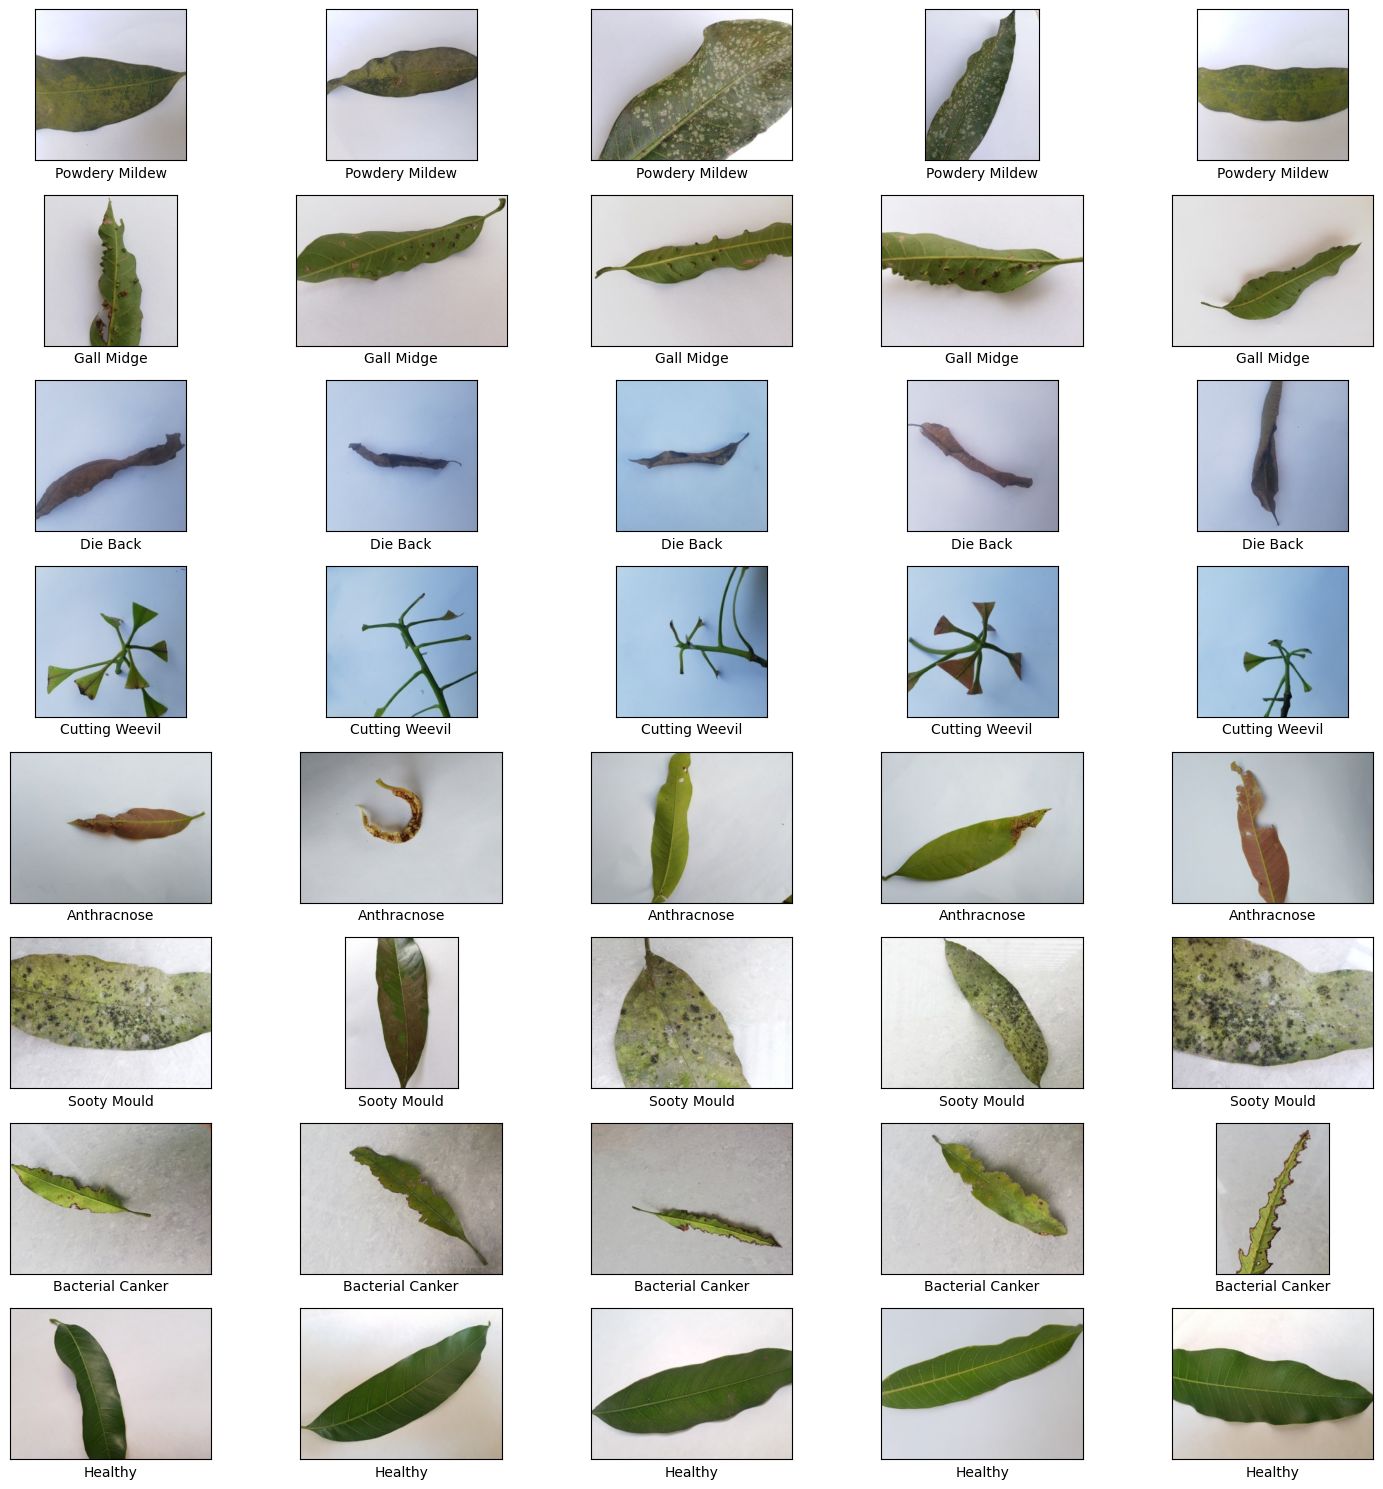

In [7]:
# Membuat kamus untuk menyimpan gambar untuk setiap kelas dalam data
mango_image = {}

# Tentukan path sumber train
path = "mango_image/"
path_sub = os.path.join(path, "dataset")

# Loop melalui setiap kelas dalam path_sub
for i in os.listdir(path_sub):
    # Menyimpan daftar gambar untuk setiap kelas dalam kamus bag_image
    mango_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data.
path_sub = "mango_image/dataset/"

# Membuat subplot untuk menampilkan gambar
fig, axs = plt.subplots(len(mango_image.keys()), 5, figsize=(15, 15))

# Loop melalui setiap kelas dalam path_sub
for i, class_name in enumerate(os.listdir(path_sub)):
    # Memilih gambar secara acak dari setiap kelas, maksimal 5 atau jumlah gambar yang tersedia
    num_images = min(5, len(mango_image[class_name]))  # Ambil jumlah gambar, maksimal 5
    images = np.random.choice(mango_image[class_name], num_images, replace=False)

    # Loop melalui setiap gambar yang dipilih
    for j, image_name in enumerate(images):
        # Membuat path lengkap untuk gambar
        img_path = os.path.join(path_sub, class_name, image_name)

        # Membuka gambar dalam mode warna (RGB)
        img = Image.open(img_path)

        # Menampilkan gambar pada subplot
        axs[i, j].imshow(img)

        # Mengatur label dan menghilangkan ticks pada sumbu x dan y
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

    # Sembunyikan subplot yang tidak digunakan jika gambar kurang dari 5
    for j in range(num_images, 5):  # Mulai dari jumlah gambar yang tersedia hingga 5
        axs[i, j].axis('off')  # Sembunyikan subplot

# Menyesuaikan layout subplot agar tidak tumpang tindih
fig.tight_layout()

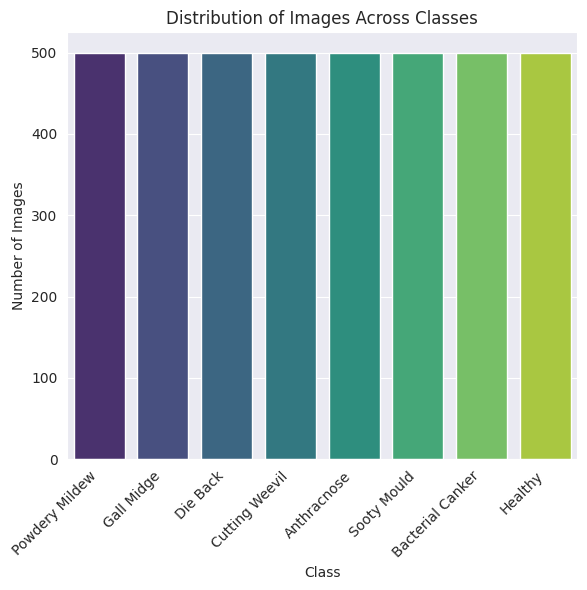

In [8]:
# Define source path
mango_path = "mango_image/dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(mango_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Menghitung jumlah gambar per kelas
label_counts = distribution_train['labels'].value_counts()

# Membuat barplot dengan warna
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")  # Menggunakan palette "viridis" untuk warna
plt.title("Distribution of Images Across Classes")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha="right")  # Rotasi label sumbu x agar tidak tumpang tindih
plt.tight_layout()
plt.show()

In [9]:
def get_image_resolution(image_path):
  """Gets the resolution of an image.

  Args:
    image_path: The path to the image file.

  Returns:
    A tuple containing the width and height of the image, or None if the image
    cannot be opened.
  """
  try:
    with Image.open(image_path) as img:
      width, height = img.size
      return width, height
  except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
    return None
  except Exception as e:
    print(f"Error opening image: {e}")
    return None


# Example usage (replace with your image paths):
image_paths = distribution_train["path"].tolist() # Assuming you have image paths stored

for image_path in image_paths[:5000]:
    resolution = get_image_resolution(image_path)
    if resolution:
        width, height = resolution
        print(f"Image: {image_path}, Resolution: {width}x{height}")

Image: mango_image/dataset/Powdery Mildew/20211109_121935 (Custom).jpg, Resolution: 240x240
Image: mango_image/dataset/Powdery Mildew/IMG_20211107_123945 (Custom).jpg, Resolution: 320x240
Image: mango_image/dataset/Powdery Mildew/IMG_20211107_124507 (Custom).jpg, Resolution: 320x240
Image: mango_image/dataset/Powdery Mildew/IMG_20211107_124933 (Custom).jpg, Resolution: 320x240
Image: mango_image/dataset/Powdery Mildew/IMG_20211107_143727 (Custom).jpg, Resolution: 240x320
Image: mango_image/dataset/Powdery Mildew/20211109_122015 (Custom).jpg, Resolution: 240x240
Image: mango_image/dataset/Powdery Mildew/IMG_20211107_124623 (Custom).jpg, Resolution: 320x240
Image: mango_image/dataset/Powdery Mildew/IMG_20211107_125226 (Custom).jpg, Resolution: 240x320
Image: mango_image/dataset/Powdery Mildew/IMG_20211107_122406 (Custom).jpg, Resolution: 240x320
Image: mango_image/dataset/Powdery Mildew/20211109_121839 (Custom).jpg, Resolution: 240x240
Image: mango_image/dataset/Powdery Mildew/20211109_1

### Data Preprocessing

In [10]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'mango_image/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Anthracnose,500
Bacterial Canker,500
Cutting Weevil,500
Die Back,500
Gall Midge,500
Healthy,500
Powdery Mildew,500
Sooty Mould,500


In [11]:
# Function to check and potentially fix image files
def check_and_fix_image(image_path):
    try:
        # Try opening the image using Pillow
        img = Image.open(image_path)
        # If successful, save it again to potentially fix minor corruption
        img.save(image_path)
        return True
    except (IOError, OSError):
        # If image cannot be opened, it's likely corrupted
        print(f"Error: Corrupted image found: {image_path}")
        # You can choose to remove or handle the corrupted image here
        os.remove(image_path)
        return False

# Iterate through all images in the test directory
for class_name in os.listdir(mypath):
    class_path = os.path.join(mypath, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        check_and_fix_image(image_path)

#### Split Dataset

In [12]:
# Path asli
original_path = "mango_image/dataset/"
base_path = "/content/split_dataset"

# Buat folder train-val-test
for split in ['train', 'val', 'test']:
    for class_dir in os.listdir(original_path):
        Path(f"{base_path}/{split}/{class_dir}").mkdir(parents=True, exist_ok=True)

# Split 70% train, 15% val, 15% test
split_ratio = (0.7, 0.15, 0.15)

for class_name in os.listdir(original_path):
    img_list = os.listdir(os.path.join(original_path, class_name))
    random.shuffle(img_list)
    n_total = len(img_list)
    n_train = int(n_total * split_ratio[0])
    n_val = int(n_total * split_ratio[1])

    for i, img_name in enumerate(img_list):
        src = os.path.join(original_path, class_name, img_name)
        if i < n_train:
            dst = os.path.join(base_path, 'train', class_name, img_name)
        elif i < n_train + n_val:
            dst = os.path.join(base_path, 'val', class_name, img_name)
        else:
            dst = os.path.join(base_path, 'test', class_name, img_name)
        shutil.copyfile(src, dst)

print("📁 Struktur folder siap di-load.")

📁 Struktur folder siap di-load.


In [13]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    base_path + "/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = test_val_datagen.flow_from_directory(
    base_path + "/val",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_val_datagen.flow_from_directory(
    base_path + "/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get class names from the class_indices attribute
class_names = list(train_generator.class_indices.keys())
print("Kelas:", class_names)

Found 2800 images belonging to 8 classes.
Found 600 images belonging to 8 classes.
Found 600 images belonging to 8 classes.
Kelas: ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']


In [14]:
# Path tujuan di Google Drive
drive_path = "/content/drive/MyDrive/Capstone Mangalyze/Mangalyze 2/Data/"

# Buat folder tujuan di Drive jika belum ada
!mkdir -p "{drive_path}train"
!mkdir -p "{drive_path}val"
!mkdir -p "{drive_path}test"

# Salin file dari folder lokal ke Drive
!cp -r "{base_path}/train/." "{drive_path}train"
!cp -r "{base_path}/val/." "{drive_path}val"
!cp -r "{base_path}/test/." "{drive_path}test"

print("📁 File train, val, dan test telah disalin ke Google Drive.")

📁 File train, val, dan test telah disalin ke Google Drive.


## Modelling

In [18]:
# Load the pre-trained model without the top classification layer
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Create a Sequential model
model = Sequential()

# Add the base model as the first layer
model.add(base_model)

# Add your custom layers
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((1, 1)))
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(train_generator.num_classes, activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 32)       │       552,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1, 1, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,107,624 (72.89 MB)

 Trainable params: 785,640 (3.00 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [19]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        if(logs.get('accuracy') > 0.99 and logs.get('val_accuracy') > 0.99):
            print("\nAkurasi train dan validasi di atas 99%! Training dihentikan.")
            self.model.stop_training = True

# Define callbacks
callbacks = MyCallback()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model with all callbacks
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[callbacks, early_stopping, reduce_lr]
)

Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.1463 - loss: 2.2969 - val_accuracy: 0.3150 - val_loss: 2.2382 - learning_rate: 1.0000e-05
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 482ms/step - accuracy: 0.2040 - loss: 2.2334 - val_accuracy: 0.3733 - val_loss: 2.1016 - learning_rate: 1.0000e-05
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 477ms/step - accuracy: 0.3189 - loss: 2.0863 - val_accuracy: 0.3983 - val_loss: 1.8401 - learning_rate: 1.0000e-05
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 83s 494ms/step - accuracy: 0.4118 - loss: 1.8622 - val_accuracy: 0.6483 - val_loss: 1.4958 - learning_rate: 1.0000e-05
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 479ms/step - accuracy: 0.5646 - loss: 1.5581 - val_accuracy: 0.7667 - val_loss: 1.1766 - learning_rate: 1.0000e-05
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 43s 483ms/step - accuracy: 0.6685 - loss: 1.2830 - val_accuracy: 0.8100 - val_loss: 0.9388 - learning_rate: 1.0000e-05
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 472ms/step - accur

## Evaluasi dan Visualisasi

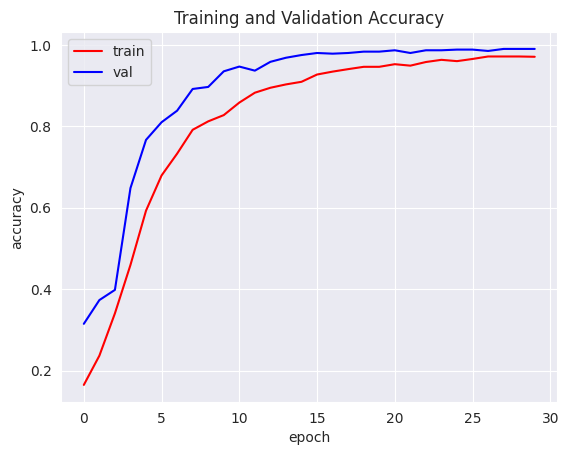

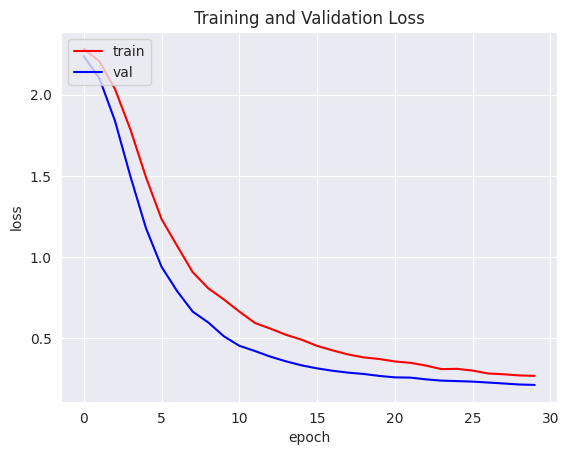

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
# Evaluasi Model untuk Testing
loss_test, acc_test = model.evaluate(test_generator)
print('Testing Loss:', loss_test)
print('Testing Accuracy:', acc_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9935 - loss: 0.2131
Testing Loss: 0.2200106531381607
Testing Accuracy: 0.9883333444595337


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        75
           1       1.00      0.99      0.99        75
           2       1.00      1.00      1.00        75
           3       1.00      1.00      1.00        75
           4       0.99      0.96      0.97        75
           5       0.97      1.00      0.99        75
           6       0.97      1.00      0.99        75
           7       1.00      0.96      0.98        75

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



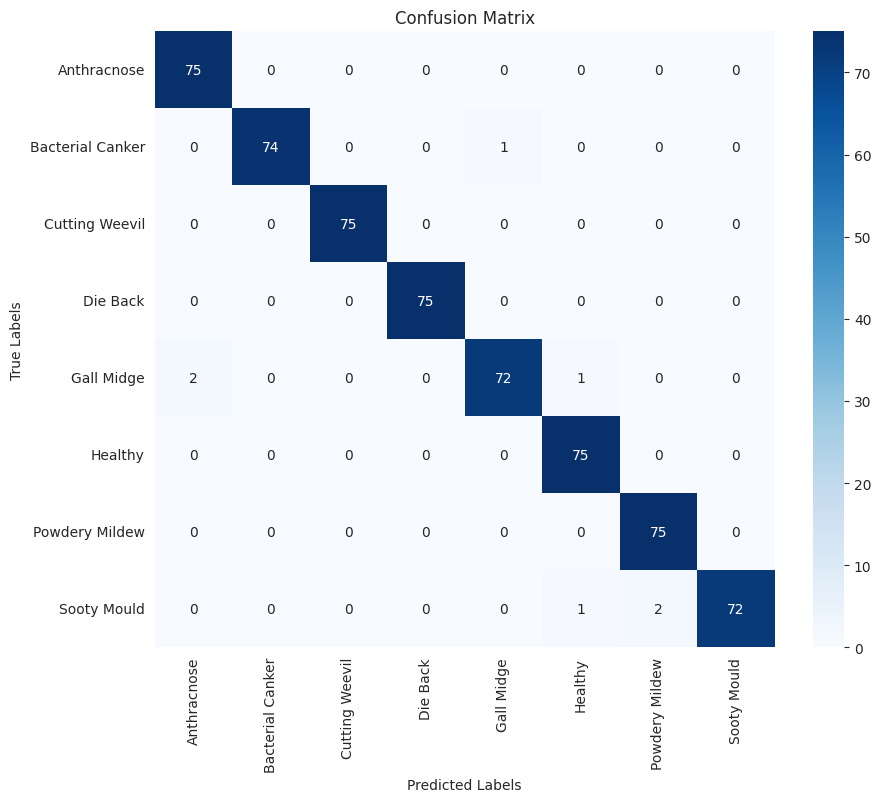

In [28]:
# Predict the labels for the test data
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = test_generator.classes

# Generate the classification report
print(classification_report(y_true, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [42]:
# Menyimpan model dalam format TensorFlow SavedModel di Google Drive
model.save('/content/drive/MyDrive/Capstone Mangalyze/Mangalyze 2/Model/densenet201.keras')

# Menyimpan model dalam format HDF5 di Google Drive
model.save('/content/drive/MyDrive/Capstone Mangalyze/Mangalyze 2/Model/densenet201.h5')

## Konversi Model

In [43]:
# Install tensorflowjs
!pip install tensorflowjs

# Convert the Keras model to TensorFlow.js format
# The output will be saved in a directory named tfjs_model in the current working directory
!tensorflowjs_converter --input_format=keras densenet201.h5 ./tfjs_model

# Copy the converted model to Google Drive
!cp -r ./tfjs_model /content/drive/MyDrive/Capstone\ Mangalyze/Mangalyze\ 2/Model/tfjs_densenet201

2025-05-29 05:37:20.854900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748497040.874767   16844 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748497040.880733   16844 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [44]:
# Menyimpan model dalam format SavedModel di Google Drive
export_dir_drive = '/content/drive/MyDrive/Capstone Mangalyze/Mangalyze 2/Model/saved_model/'
tf.saved_model.save(model, export_dir_drive)

# Convert SavedModel menjadi densenet201.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir_drive)
tflite_model = converter.convert()

# Menyimpan model TFLite di Google Drive
tflite_model_file_drive = pathlib.Path('/content/drive/MyDrive/Capstone Mangalyze/Mangalyze 2/Model/densenet201.tflite')
tflite_model_file_drive.write_bytes(tflite_model)

819440

## Inference (Optional)

Predicted class: Cutting Weevil


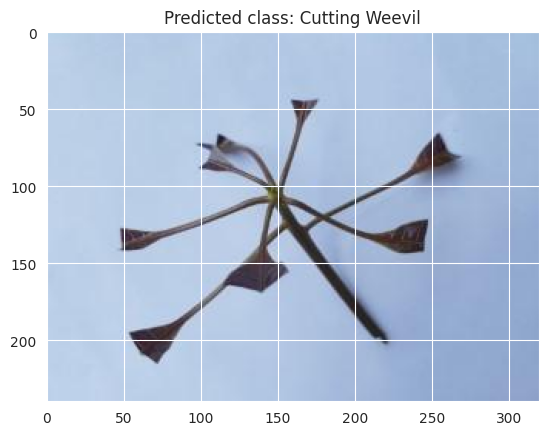

In [46]:
# Load the SavedModel
loaded_model = tf.saved_model.load('/content/drive/MyDrive/Capstone Mangalyze/Mangalyze 2/Model/saved_model/')

def preprocess_image(image_path):
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img) / 255.0
    # Change data type to float32
    img_array = img_array.astype(np.float32)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

image_path = '/content/mango_image/dataset/Cutting Weevil/20211011_131115 (Custom).jpg'
preprocessed_image = preprocess_image(image_path)

# Perform inference
infer = loaded_model.signatures["serving_default"]
# Get the output layer's name from the model's outputs
output_layer_name = list(infer.structured_outputs.keys())[0]
predictions = infer(tf.constant(preprocessed_image))[output_layer_name]

# Get the predicted class
predicted_class = np.argmax(predictions)

# Define a dictionary to map class indices to class names
class_names = {
    0: 'Anthracnose',
    1: 'Bacterial Canker',
    2: 'Cutting Weevil',
    3: 'Die Back',
    4: 'Gall Midge',
    5: 'Healthy',
    6: 'Powdery Mildew',
    7: 'Sooty Mould'
}

# Get the predicted class name
predicted_class_name = class_names[predicted_class]

# Print the predicted class name
print(f"Predicted class: {predicted_class_name}")

# Display the image
img = mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.title(f"Predicted class: {predicted_class_name}")
plt.show()

Saving sooty mould.jpg to sooty mould (1).jpg
Predicted class: Sooty Mould


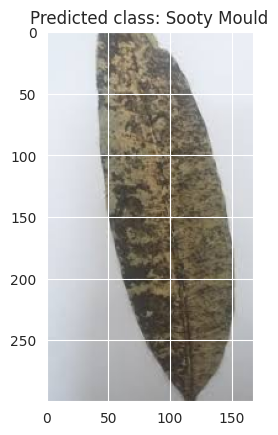

In [47]:
# Load the SavedModel
loaded_model = tf.saved_model.load('/content/drive/MyDrive/Capstone Mangalyze/Mangalyze 2/Model/saved_model/')

def preprocess_image(image_path):
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img) / 255.0
    # Change data type to float32
    img_array = img_array.astype(np.float32)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Upload image using files.upload()
from google.colab import files
uploaded = files.upload()

# Get the uploaded image path
image_path = list(uploaded.keys())[0]
preprocessed_image = preprocess_image(image_path)

# Perform inference
infer = loaded_model.signatures["serving_default"]
# Get the output layer's name from the model's outputs
output_layer_name = list(infer.structured_outputs.keys())[0]
predictions = infer(tf.constant(preprocessed_image))[output_layer_name]

# Get the predicted class
predicted_class = np.argmax(predictions)

# Define a dictionary to map class indices to class names
class_names = {
    0: 'Anthracnose',
    1: 'Bacterial Canker',
    2: 'Cutting Weevil',
    3: 'Die Back',
    4: 'Gall Midge',
    5: 'Healthy',
    6: 'Powdery Mildew',
    7: 'Sooty Mould'
}

# Get the predicted class name
predicted_class_name = class_names[predicted_class]

# Print the predicted class name
print(f"Predicted class: {predicted_class_name}")

# Display the image
img = mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.title(f"Predicted class: {predicted_class_name}")
plt.show()

In [48]:
!pip freeze > requirements.txt